In [126]:
import os, sys
sys.path.insert(0, os.path.dirname(os.getcwd()))
sys.path.insert(0, os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'DeepUnitMatch'))
import UnitMatchPy.default_params as default_params
import UnitMatchPy.utils as util
import UnitMatchPy.overlord as ov
import UnitMatchPy.bayes_functions as bf
import matplotlib.pyplot as plt
import numpy as np
from DeepUnitMatch.utils import param_fun
from DeepUnitMatch.testing import test

In [2]:
# Getting the data the same way as UnitMatch

# Get default parameters, can add your own before or after!
param = default_params.get_default_param()

# Give the paths to the KS directories for each session
# If you don't have a dir with channel_positions.npy etc look at the detailed example for supplying paths separately 
KS_dirs = [r'\\znas\Subjects\AL032\2019-11-21\ephys_K1\pyKS\output', r'\\znas\Subjects\AL032\2019-11-22\ephys_K1\pyKS\output']

param['KS_dirs'] = KS_dirs
wave_paths, unit_label_paths, channel_pos = util.paths_from_KS(KS_dirs)
param = util.get_probe_geometry(channel_pos[0], param)

# STEP 0 from the UMPy example notebook
waveform, session_id, session_switch, within_session, good_units, param = util.load_good_waveforms(wave_paths, unit_label_paths, param, good_units_only = True) 

Using BombCell: cluster_bc_unitType
Using BombCell: cluster_bc_unitType


In [3]:
# Preprocess the DeepUnitMatch way and save as HDF5 files for each session in 'processed_waveforms'.
snippets, positions = param_fun.get_snippets(waveform, channel_pos, session_id)

# Load the neural net
model = test.load_trained_model(device="cpu")

# We have stored the preprocessed data here (from the get_snippets function)
data_dir = os.path.join(os.path.dirname(os.getcwd()), 'DeepUnitMatch', 'processed_waveforms')

# Pass the preprocessed data through the neural net
sim_matrix = test.inference(model, data_dir)

Initialised with 352 files in the dataset.
No. of experiment batches: 2


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


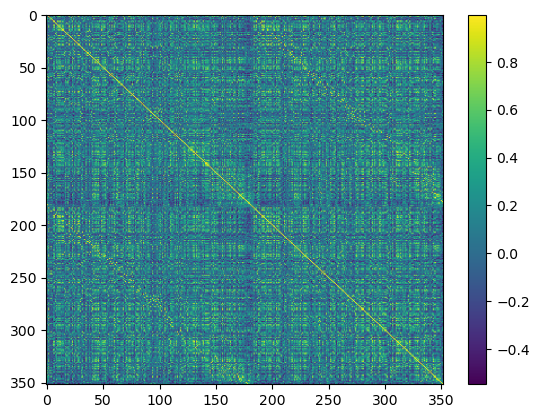

In [4]:
# Visualise the similarity matrix
plt.imshow(sim_matrix, cmap='viridis', aspect='auto')
plt.colorbar()

In [5]:
# STEP 1
# Extract parameters from waveform. We only need the distance matrix in DeepUnitMatch.
clus_info = {'good_units' : good_units, 'session_switch' : session_switch, 'session_id' : session_id, 
            'original_ids' : np.concatenate(good_units) }
extracted_wave_properties = ov.extract_parameters(waveform, channel_pos, clus_info, param)                  # contains spatial locations
distance_matrix, candidate_pairs, scores_to_include, predictors  = ov.extract_metric_scores(extracted_wave_properties, session_switch, within_session, param, 
                                                                                        niter  = 2, to_use=['centroid_dist'])

c:\Users\suyas\AppData\Local\anaconda3\envs\unitmatch\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: invalid value encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])


In [112]:
# Use the same Naive Bayes as in UnitMatchPy

# Get prior probability of being a match
prior_match = 1 - (param['n_expected_matches'] / param['n_units']**2 ) # freedom of choose in prior prob
priors = np.array((prior_match, 1-prior_match))
labels = candidate_pairs.astype(int)
cond = np.unique(labels)
parameter_kernels = bf.get_parameter_kernels(scores_to_include, labels, cond, param, add_one = 1)
probability = bf.apply_naive_bayes(parameter_kernels, priors, predictors, param, cond)
output_prob_matrix = probability[:,1].reshape(param['n_units'],param['n_units'])

Calculating the probability distributions of the metric scores
Calculating the match probabilities


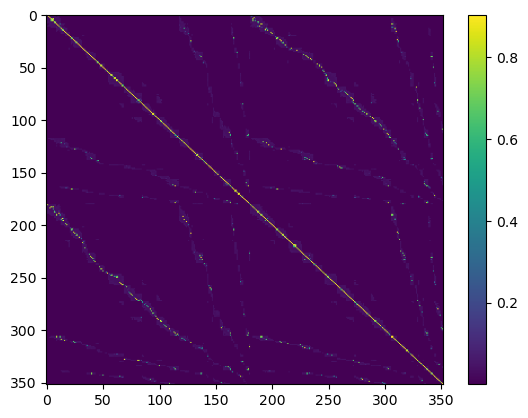

In [ ]:
# Visualise the output probability matrix

plt.imshow(output_prob_matrix, cmap='viridis', aspect='auto')
plt.colorbar()

In [ ]:
# UnitMatchPy evaluation function

util.evaluate_output(output_prob_matrix, param, within_session, session_switch, match_threshold = 0.5)

The percentage of units matched to themselves is: 98.86%
The percentage of false -ve's then is: 1.14% 

The rate of miss-match(es) per expected match 0.72
The percentage of false +ve's is 0.00% for session 1
The percentage of false +ve's is 0.00% for session 2

This assumes that the spike sorter has made no mistakes


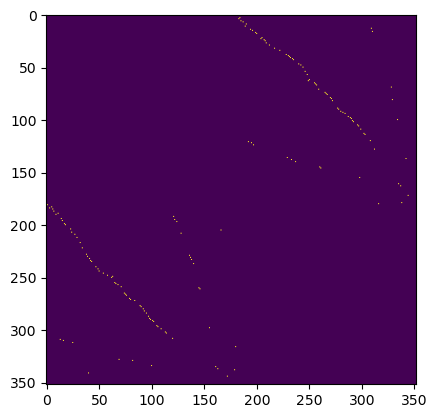

In [ ]:
# Process the output probability matrix to get final set of matches (across sessions)
within_session = (session_id[:, None] == session_id).astype(int)
probs = output_prob_matrix.copy()
probs[within_session == True] = 0
matches = probs > 0.5
dir_filtered = test.directional_filter(matches)         # make the matching critera more stringent
dir_filtered_matches = dir_filtered > 0.5
confout = test.remove_conflicts(dir_filtered)           # ensure each neuron is only matched once
plt.imshow(confout)